In [1]:
from   matplotlib  import pyplot as plt

from   scipy.fft   import fft, ifft
from   scipy.stats import multivariate_normal

import numpy  as np
import pandas as pd

import os

In [2]:
# read in the raw data
data = {}

for file in os.listdir('data'):
    num = int(file[1:])
    data[num] = [pd.read_csv(f'data/{file}/{f}', header = None) for f in sorted(os.listdir(f'data/{file}'))]
    
# remove exception files
# 9  (2) has 10 rows
# 33 (2) has weird max value in column B
for exception in [9, 33]:
    del data[exception]
    
X1, X2, X0 = zip(*data.values())

# extract features from each corresponding x file
Z0, Z1, Z2 = [], [], []

for (X, Z) in zip([X0, X1, X2], [Z0, Z1, Z2]):
    
    for x in X:
        z = []
        x = np.array(x)[:,1:]                                                                # ignore time column

        # loop through the raw data and fft of data and obtain the features mean, min, max, and std
        for xf in [x, abs(fft(x))]:
            z.append(xf.mean(axis = 0))
            z.append(xf.min(axis = 0))
            z.append(xf.max(axis = 0))
            z.append(xf.std(axis = 0))

        # compute mean and std of the interval between the peaks
        f = pd.DataFrame(x).rolling(5, min_periods = 5, center = True).mean().values[2:-2,0] # smooth local simple average of breathe
        d = np.where((f[1:-1] > f[:-2]) & (f[1:-1] > f[2:]))[0]                              # local peak indices
        d = d[1:] - d[:-1]                                                                   # redefine to be interval between peaks

        z.append([d.mean()])
        z.append([d.std()])

        # flatten all features and append
        z = np.concatenate(z)
        Z.append(z)

Z0, Z1, Z2 = map(np.array, [Z0, Z1, Z2])

# define computed features (4 x 3 x 2 + 2)
features  = [f'{fun} {feat}' for fun in ['mean', 'min', 'max', 'std'] for feat in ['breathe', 'pressure', 'cycle']]
features += [f'fft {f}' for f in features]
features += ['mean interval', 'std interval']

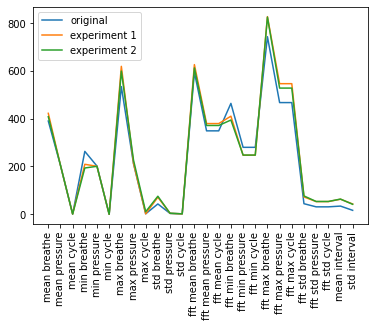

In [3]:
# visualise mean feature values across participants to see if there is a visual difference
labels = ['original', 'experiment 1', 'experiment 2']

for Z, label in zip([Z0, Z1, Z2], labels):
    plt.plot(Z.mean(axis = 0), label = label)

plt.xticks(range(len(features)), features, rotation = 90)

plt.legend()
plt.show()

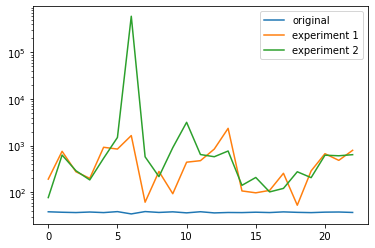

In [4]:
# fit a multivariate normal on the original experiment data
m, C = Z0.mean(axis = 0), np.cov(Z0, rowvar = False)

N  = multivariate_normal(m, C, allow_singular = True)

# define the log probability for each experimental design (3 rows)
lp = np.array([N.logpdf(Z) for Z in [Z0, Z1, Z2]])

# visualise the negative log probability
# x-axis is each participant
# y-axis is the negative log probability of belonging to the original dataset (note clear gap between blue and non-blue lines)
for l, label in zip(lp, labels):
    plt.semilogy(-l, label = label)

plt.legend()
plt.show()